# Project 3. Behavioral cloning
## Udacity Self-driving car Nanodegree
## Objectives


The goals / steps of this project are the following:

1.  Use the simulator to collect data of good driving behavior
2.  Build, a convolution neural network in Keras that predicts steering angles from images
3.  Train and validate the model with a training and validation set
4.  Test that the model successfully drives around track one without leaving the road
5.  Summarize the results with a written report





### Project Writeup by Albert Vo
---
Once you have completed the code implementation, document your results in a project writeup using this template as a guide. The writeup can be in a markdown or pdf file. 

This P3 Behavior Cloning Notebook represents my project code and also my project writeup. I have included other formats including PDF and HTML versions of this notebook.

References and Attributions:
1.  Albert Vo Code and Writeup 
2.  Udacity Course Material
3.  Vivek Yadav Github

# Outline
### 1.  Data
### 2.  Data Preprocessing
### 3.  Model
### 4.  Training
### 5.  Testing
  


# 1.  Files Submitted:

Are all required files submitted?

Answer:

The submission includes a model.py file, drive.py, model.h5 a writeup report and video.mp4

####1. Submission includes all required files and can be used to run the simulator in autonomous mode

My project includes the following files:

1.  model.py containing the script to create and train the model
2.  drive.py for driving the car in autonomous mode
3.  model.json containing the training weights as JSON
3.  model.h5 containing a trained convolution neural network
4.  writeup_report.md or writeup_report.pdf summarizing the results



# 2.  Code Quality:

Is the code functional?

Answer:

My code is functional and can be used to drive the car in Udacity simulator in Autonomous mode.
To use my code to drive in Autonomous mode, run the following:  (Note:  use model.json, not model.h5)

python drive.py model.json



Is the code usable and readable?

Answer:

I organized my code into modular format and put them in Jupyter notebook cells.
I included headings, comments and relevant information.
Most importantly, I provided answers to all the questions posed in the Behavior Cloning Project Rubric. 
I also made sure that the code was efficient by using Keras Generators.  
See below for more detailed description of Generators. 

### Generators
Rather than storing training data in memory, 
I used a Python generator to generate data for training.

The images captured in the car simulator are much larger than the images encountered in the Traffic Sign Classifier Project, a size of 160 x 320 x 3 compared to 32 x 32 x 3. Storing 10,000 traffic sign images would take about 30 MB but storing 10,000 simulator images would take over 1.5 GB. That's a lot of memory! Not to mention that preprocessing data can change data types from an int to a float, which can increase the size of the data by a factor of 4.

Using a generators was a great way to work with large amounts of data. Instead of storing the preprocessed data in memory all at once, I could pull pieces of the data and process them on the fly only when I needed them.



# 1.  Data

#Data

In the Behavior Cloning project I trained a Convolutional Neural Network to drive a car in a simulator.  The goal of the project was to be able to train the CNN model so that the model can predict steering angles based on images from the car's cameras.  

For training data, I not only used Udacity provided data set, but I also augmented the dataset with my own training data to add recovery and other "generated" data.  I felt that the Udacity data was good for using as a baseline, but I also wanted to provide the model with more scenarios to learn from.

The Udacity simulator has two modes:  Autonomous Mode and Training Mode.  To collect training data, I drove the car in training mode and the simulator recorded not only the camera images, but also the corresponding steering angles in the training log.  The simulator logged all the data (the path to each still image or frame, the steering angle, throttle, brake and speed of the car in the training laps) in a CSV file called driving_log.csv.  The car has three cameras: front facing, on the left and right of the car, giving three angles or perspectives for each training instant.  In Autonomous mode, the Udacity simulator used the trained model to predict the steering angle based on the camera images and to effectively drive the car by itself.

Here is an example of my training-log image data.

![alt text](myimages/training-log.jpg "Training data")

Img 1. Training data log

The first step was to investigate the training data. The steering angles were normalized between -1 and 1.
I explored the data set by plotting out the distribution of the steering angles.  
From the plot, it was clear that the angle distribution was not even because most of the steering angle was zero.


![alt text](myimages/data_distribution_before_3.png "Training data steering angle distribution")

Img 2. Distribution of the steering angles in the training data

In order to feed the Neural Network a more even distribution of angles and downsample the zero angles I chose to load only angles above or below 0.35 steering values.  This had the effect of filtering out the smaller angles and resulted in a more even distribution.  This way the model will not be biased towards going straight all the time.

![alt text](myimages/imported-data-steering-dist.png "Imported data steering angle distribution")




In [1]:
# P3 Training Data Exploration
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import time
import shutil
import os
import random
import cv2
import math
import json
import seaborn as sns 
import tensorflow as tf

import keras
from keras.preprocessing.image import *
from keras.models import Sequential, Model
from keras.layers import Convolution2D, Flatten, MaxPooling2D, Lambda, ELU
from keras.layers.core import Dense, Dropout, Activation
from keras.optimizers import Adam
from keras.callbacks import Callback
from keras.layers.normalization import BatchNormalization
from keras.regularizers import l2

from IPython.display import display # Allows the use of display() for DataFrames

# Visualizations will be shown in the notebook.
%matplotlib inline

# fix random seed for reproducibility
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)
tf.reset_default_graph()

columns = ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed']
data = pd.read_csv('driving_log.csv', names=columns)

print("Dataset Columns:", columns, "\n")
print("Shape of the dataset:", data.shape, "\n")
print(data.describe(), "\n")

print("Data loaded...")

Using TensorFlow backend.


Dataset Columns: ['center', 'left', 'right', 'steering_angle', 'throttle', 'brake', 'speed'] 

Shape of the dataset: (8061, 7) 

                                        center  \
count                                     8061   
unique                                    8060   
top     IMG/center_2017_05_28_09_38_30_249.jpg   
freq                                         2   

                                        left  \
count                                   8061   
unique                                  8060   
top     IMG/left_2017_05_28_09_38_30_249.jpg   
freq                                       2   

                                        right steering_angle   throttle brake  \
count                                    8061           8061       8061  8061   
unique                                   8060            135         96    24   
top     IMG/right_2017_05_28_09_38_30_249.jpg              0  0.9855326     0   
freq                                        2          

0       steering
1              0
2             -1
3             -1
4             -1
5              1
6              1
7              1
8     -0.6000001
9     -0.8000001
10    -0.9500002
11            -1
12            -1
13            -1
14            -1
15    -0.8152856
16    -0.6446955
17    -0.6500001
18    -0.8500001
19            -1
20            -1
21            -1
22            -1
23            -1
24    -0.8321736
25    -0.5887434
26             0
27             0
28             0
29             0
         ...    
70             0
71             0
72             0
73             0
74             0
75             0
76             0
77     0.0617599
78    0.05219137
79    0.05219137
80     0.3679529
81     0.5784606
82     0.5784606
83     0.1670138
84             0
85             0
86             0
87             0
88             0
89             0
90             0
91             0
92             0
93             0
94             0
95    0.08089697
96     0.0904655
97     0.09046

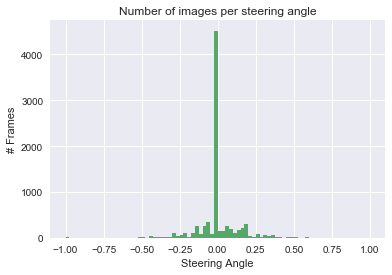

In [2]:
#  Training Data Steering Angle Distribution
binwidth = 0.025

print (data.steering_angle[0:100])

mysteer=data.steering_angle
mysteer1 =mysteer[1:]
#steer_floats = [float(x) for x in s.split()]

steer_floats = [float(x) for x in mysteer1]

# histogram before image augmentation
#plt.hist(data.steering_angle,bins=np.arange(min(data.steering_angle), max(data.steering_angle) + binwidth, binwidth))
#plt.hist(data.steering_angle,bins=np.arange(min(data.steering_angle), max(data.steering_angle) + binwidth, binwidth))

#plt.subplots(figsize=(3, 12))
plt.hist(steer_floats,bins=np.arange(min(steer_floats), max(steer_floats) + binwidth, binwidth))
plt.hist(steer_floats,bins=np.arange(min(steer_floats), max(steer_floats) + binwidth, binwidth))


plt.title('Number of images per steering angle')
plt.xlabel('Steering Angle')
plt.ylabel('# Frames')
plt.show()

# Data Augmentation

[//]: # (Image References)

[image1]: myimages/left_center_right.jpg "Left Center Right Camera Perspectives"
[image2]: track2.jpg "Track2"
[video1]: ./Track1.mp4 "Track1 Video"
[video2]: ./Track2.mp4 "Track2 Video"

---

# Recovery Training


To generate recovery data, I fed the left and right camera images to my model as if they were coming from the center camera. This simulates the car being off center either to the left and to the right.  By adding a correction to the steering angle which is based on the center camera, I teach my model how to steer if the car drifts off to the left or the right.

I experimented with the correction value, observing how well the model performs and made adjustments to the correction value until the car is able to drive successfully around the track.


  
# Left Center Right Camera Perspectives

![alt text][image1]

There are three camera angles for every training drive:  Left, Center and Right.
Since the steering_angle in the training set is associated with the Center camera, I add the Center Camera image and steering_angle without modification.  For the Left Camera image, I add the image and add 35 degrees to the steering_angle to represent the correction needed to steer from the Left Camera image to get back to Center.
For the Right Camera image, I add the image and subtract 35 degrees to the steering_angle to represent the correction needed to steer from the Right Camera image to get back to Center.


# Data 

[//]: # (Image References)

[image1]: myimages/left_center_right.jpg "Left Center Right Camera Perspectives"
[image2]: my_data_augment.jpg "My Data Augmentation"
[image3]: myimages/Original.jpg "Original Image"
[image4]: myimages/Cropped.jpg "Cropped Image"
[video1]: ./Track1.mp4 "Track1 Video"
[video2]: ./Track2.mp4 "Track2 Video"

---

# Data Preprocessing:  
# normalizing, resizing, cropping

The images are 320 x 160 pixels in three color channels.

The data is split into 80% for training and 20% kept aside as validation data.
The data is randomly shuffled so as to prevent using the same images all the time.

I have resized the images to half their size in pixels to save memory.
I have also cropped the images to eliminate unwanted areas that don't provide important information, like the skyline or the car bonnet.


# cropping
The cameras in the simulator capture 160 pixel by 320 pixel images.

I crop out the top portion of the image and get rid of the trees and hills and sky, and the bottom portion of the image and get rid of the hood of the car.

Cropping the image so that it only focuses on only the portion of the image that is useful for predicting a steering angle not only makes the predictions more accurates, but also speeds up training.


![alt text][image3]

![alt text][image4]


# Data Augmentation
# Adding random brightness, flipping, perspective transforms

I wanted to add data to represent more scenarios and conditions for the model to train on and learn from.
I have then changed their brightness level by a random value to simulate driving in different light conditions
I have added a random chance of horizontal flipping of the image and multiplying the steering angle by -1.

Images with random brightness to simulate driving in different lighting conditions.

Images with random perspective transformations to simulate driving uphill and downhill.


![alt text][image2]





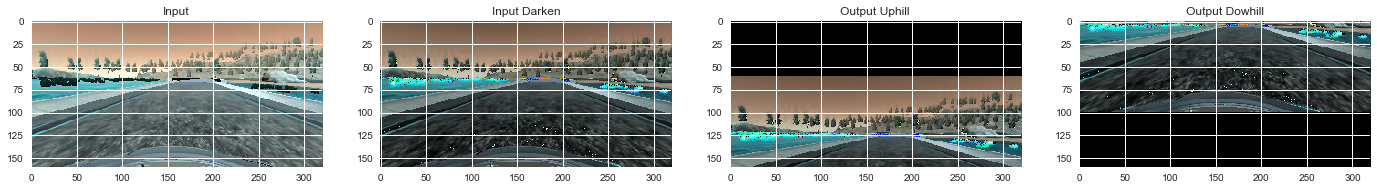

In [3]:
#  Data Augmentation:
#  Brightnes (Darken Image)
#  Perspective Transforms (Go Uphill and Go Downhill)

def brightness_shift(img, bright_value=None):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
    
    if bright_value:
        img[:,:,2] += bright_value
    else:
        random_bright = .25 + np.random.uniform()
        img[:,:,2] = img[:,:,2] * random_bright
    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    return img


img_in = cv2.imread("myimages/center_2016_12_01_13_32_43_457.jpg")
# darken image
img = brightness_shift(img_in, 200)

pts1 = np.float32([[0,60],[0,120],[300,60],[300,120]])
# Go Uphill
pts2 = np.float32([[0,120],[0,180],[300,120],[300,180]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img,M,(320,160))


pts1 = np.float32([[0,60],[0,120],[300,60],[300,120]])
# Go Downhill
pts2 = np.float32([[0,0],[0,60],[300,0],[300,60]])
M2 = cv2.getPerspectiveTransform(pts1,pts2)
dst2 = cv2.warpPerspective(img,M2,(320,160))


 
plt.subplots(figsize=(24, 96))

plt.subplot(141),plt.imshow(img_in),plt.title('Input')
plt.subplot(142),plt.imshow(img),plt.title('Input Darken')
plt.subplot(143),plt.imshow(dst),plt.title('Output Uphill')
plt.subplot(144),plt.imshow(dst2),plt.title('Output Dowhill')

plt.show()

# Model Architecture


# Model

### Pipeline (Images)
[//]: # (Image References)
[image1]: ./myimages/comma_ai.jpg "comma.ai model"
[image2]: ./examples/random_noise.jpg
[image3]: ./examples/LeNet.jpg
[image4]: ./examples/visualization.jpg

---

1.  Has an appropriate model architecture been employed for the task?

Answer:

I chose to use a convolution neural network based on comma.ai's driving model.

To introduce non-linearity to the neural network, I used a RELU activation function.
This allows the neural network to learn non-linear functions.

To measure the performance of my model during training, I used Mean Square Error to measure the loss during training.  During training, when I saw that the mean squared error was low on a training set but high on a validation set, I knew that my model was overfitting.  The reason for overfitting probably was because there was too little data.  To reduce overfitting, I collected more data by recording more training laps and generating more augmented data.


# Comma.ai Model

![alt text][image1]

I have used and Adam optimizer and I used the MSE metric to measure the loss.
The model has been created using Keras's Sequential model.
The first layer is a Lamda layer that applies image normalization.



# Lambda layer Image Normalization

I used a lambda layer to parallelize image normalization and 
to ensure that the model will normalize input images when making predictions in drive.py.

The lambda layer takes each pixel in an image and runs it through the formulas:
pixel_normalized = pixel / 255
pixel_mean_centered = pixel_normalized - 0.5
The lambda layer:
Lambda(lambda x: (x / 255.0) - 0.5)


# Comma.ai Model Key Features and Parameters:

1.  A normalization layer on the top of the network to normalize the input images.
2.  Convolutional layer, 16 feature maps with a size of 8×8, an Exponential Linear Unit(elu) activation function.
3.  Convolutional layer, 32 feature maps with a size of 5×5, an elu activation function.
4.  Convolutional layer, 64 feature maps with a size of 5×5, an elu activation function.
5.  Flatten layer.
6.  Dropout set to 20%.
7.  ELU non-linearity layer
8.  Fully connected layer with 512 units and a elu activation function.
9.  Dropout set to 50%.
10.  ELU non-linearity layer
11.  Fully connected output layer with 1 unit 


# Training Strategy and Documentation


### Training

1.  Is the training data chosen appropriately?

Answer:

I found that the most important and probably the most challenging aspect of this project was getting good training data.  I used both the training data provided by Udacity as well as my own training data. 

I used a python generator to feed training and validation data to the model while training using the Keras fit_generator() function.
I have added a callback to the model so that it saves the best weights of each training session to file model.h5
I used a batch size of 128 for 10 epochs.
The model is very fast as training takes under 1 minute on a i7 CPU with Nvidia GTX 1070 GPU.
The model has been saved as model.json at the end of each training session.


### Validating Network

In order to validate my network, I compared model performance on the training set and a validation set. 

Since the validation set contains images and steering data that was not used for training, I can use the validation set to give me indication of whether my model is overfitting.  Using the validation data set allows me to continue to improve my training accuracy by testing accuracy on data that the model has not seen before without "dipping into" the test set which is used for "final" verification. 

I used 80% of my data for training and 20% for validation and I made sure to randomly shuffle the data before splitting into training and validation sets.

One of the problems I ran into was when mean squared error was high on both the training and the validation set.  This meant that model was underfitting. To fix this problem, I increased the number of epochs

Another problem I ran into was getting a low mean squared error for the training set, but a high mean squared error for the validation set.  This meant that the model was overfitting.  
To fix overfitting, I increased dropout and pooling layers and collected more training data through recording more driving data and generating more augmented data.

I stopped training the model when it was able to make good predictions not only on the training but also the validation sets. Then I tested with test set which it had not seen before (Track 2). In other words, I wanted to make sure that my car was able to drive around not only Track 1, but also Track 2.


# Simulation
[//]: # (Image References)

[image1]: myimages/track1.jpg "Track1"
[image2]: myimages/track2.jpg "Track2"
[video1]: ./Track1.mp4 "Track1 Video"
[video2]: ./Track2.mp4 "Track2 Video"

---



### Testing



Is the car able to navigate correctly on test data?

Answer:

I have successfully tested the model driving around both tracks in autonomous mode. 
I made sure to feed the network examples of good driving behavior so that the car tried to stay in the center and recovered when the car got too close to the sides of the road.

Even though this is just a simulation, I wanted to make sure that safety was the primary consideration whether the model's autonomous driving was successful or not. 
I made sure that the car tire did not leave the drivable portion of the track surface or pop up onto ledges or roll over any surfaces that would otherwise be considered unsafe.

The model has been trained with images from this track:  Track 1.

![alt text][image1]



After I was able to get the car to drive successfully on Track 1, I wanted to test if the car could drive in autonomous mode around Track 2, a track it had never seen before.

Since the model had never seen Track 2 before, Track 2 was the equivalent of the testing data. By being able to drive around Track 2 successfully, the model showed could generalize and was not overfitting where it was only able to drive around Track 1.

![alt text][image2]



---

#  Discussion


Answer:
I encountered a number of problems while working on this project.  At the beginning, my car would run off the track because it kept going straight when it saw a curve.  By plotting the steering angle distribution, it was clear that the vast majority of the steering angles were at or near zero.  This meant that the model learned to be biased towards going straight. 
I normalized the data distribution and I reduced the number of zero or near-zero steering angles so that the car would learn to make turns successfully.

In addition to Udacity provided training data, I recorded my own training data by driving around two full laps around Track 1.  I also added another lap of recovery data where I drove on the side of the road and steered the car back towards the center.  One of the main challenges I found was trying to drive smoothly around the curves because if the car veered to close to the sides, the model would learn "poor" examples of driving behavior.

To combat overfitting and make the model more generalizable, I generated and created additional augmented data.  I used OpenCV functions to randomly altered the original image so that the car would have more scenarios and conditions to train and learn from.



# Videos
[//]: # (Image References)

[image1]: myimages/track1.jpg "Track1"
[image2]: myimages/track2.jpg "Track2"
[video1]: ./Track1.mp4 "Track1 Video"
[video2]: ./Track2.mp4 "Track2 Video"

---


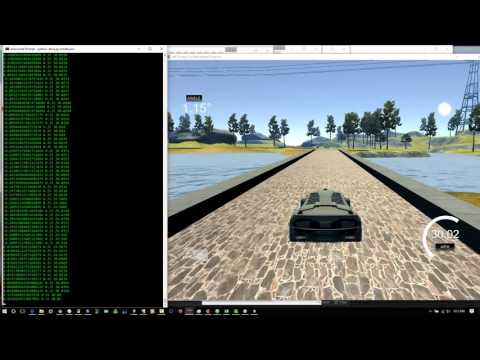

In [4]:
# Track 1
from IPython.display import YouTubeVideo
YouTubeVideo('hd-hLDxbnf0')

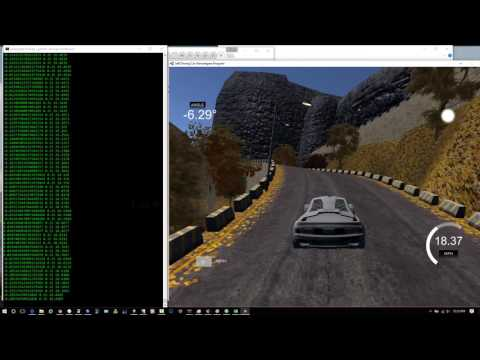

In [5]:
# Track 2
from IPython.display import YouTubeVideo
YouTubeVideo('Ukz3D9UIYxE')